# LSTM for word representations in human brain tutorial



## Introduction ##
Language encoding models can help us understand the underlying mechanisms of language processing in the human brain. Alexander Huth explains how he uses a 985-dimensional word embedding to model FMRI response in [this tutorial](https://github.com/HuthLab/speechmodeltutorial). This word embedding method however, uses a quite outdated method. He also has a [follow-up paper](https://papers.nips.cc/paper/7897-incorporating-context-into-language-encoding-models-for-fmri) where he uses an LSTM to train the word representations to respond to context. This notebook is an extension of his own tutorial, where we use a more advanced word embedding method, as well as showing an example implementation of the LSTM, since his own tutorial does not contain it. 

All the libraries needed in this tutorial, the nlp_fmri_utils file contains some functions do most of the analysis and pre-processing for us.

In [1]:
# configurations and imports
import nlp_fmri_utils as nlp_utils
from matplotlib.pyplot import figure, cm
import matplotlib.pyplot as plt
import numpy as np
import logging
import keras as kr
from keras.layers import LSTM, Dense, Masking
from keras.models import Sequential
from keras import backend as K
from keras.optimizers import Adam

logging.basicConfig(level=logging.DEBUG)

Using TensorFlow backend.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [41]:
# run this to download the datafiles from the web
import requests
import zipfile
import os
from os import path

if not path.exists("stories.csv"): 
    r1 = requests.get('https://www.kaggle.com/shubchat/1002-short-stories-from-project-guttenberg/download', allow_redirects=True)
    open('stories.csv', 'wb').write(r1.content)

if not path.exists("glove_embeds.txt"): 
    r2 = requests.get('http://nlp.stanford.edu/data/glove.6B.zip', allow_redirects=True)
    open('glove.6B.zip', 'wb').write(r2.content)
    
    with zipfile.ZipFile('glove.6B.zip') as z:
        with open('glove_embeds.txt', 'wb') as f:
            f.write(z.read('glove.6B.50d.txt'))
    
    

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): nlp.stanford.edu:80
DEBUG:urllib3.connectionpool:http://nlp.stanford.edu:80 "GET /data/glove.6B.zip HTTP/1.1" 302 308
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): nlp.stanford.edu:443
DEBUG:urllib3.connectionpool:https://nlp.stanford.edu:443 "GET /data/glove.6B.zip HTTP/1.1" 301 345
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): downloads.cs.stanford.edu:80
DEBUG:urllib3.connectionpool:http://downloads.cs.stanford.edu:80 "GET /nlp/data/glove.6B.zip HTTP/1.1" 200 862182613


## Part 1: the word embedding
To represent each word in the text, a pre-trained word embedding is used. The word embedding we use is a 50 dimensional GloVe embedding. We use a pre-trained word embedding because doing the embedding in this tutorial will be too time consuming. The GloVe embedding algorithm takes a sparse word co-occurrence matrix and turns it into a dense word embedding matrix. For more information on how this embedding works, check the [original paper](https://nlp.stanford.edu/projects/glove/). 

The load_word_embeddings function from nlp_utils will take the pre-trained embeddings' text file and store it as a dictionary and numpy array. The dictionary contains the actual words and the index where the vector of that word is stored. The embedding contains 40 thousand words with 50 dimensions each, so this might take a minute.

In [42]:
glove_dict, glove_vects = nlp_utils.load_word_embeddings(f'glove_embeds.txt')

Made an embedding containing  400000 words.


We check if the embeddings have been parsed correctly by seeing if the shape is correct. The array should be of shape n_words x n_dimensions. We can also test if we can find the vector of a particular word

In [43]:
print("vector matrix shape:", glove_vects.shape)
test_word = 'cheese'
print(f"the word vector of the word {test_word} is: ", glove_vects[glove_dict[test_word]])

vector matrix shape: (400000, 50)
the word vector of the word cheese is:  [-0.053903 -0.30871  -1.3285   -0.43342   0.31779   1.5224   -0.6965
 -0.037086 -0.83784   0.074107 -0.30532  -0.1783    1.2337    0.085473
  0.17362  -0.19001   0.36907   0.49454  -0.024311 -1.0535    0.5237
 -1.1489    0.95093   1.1538   -0.52286  -0.14931  -0.97614   1.3912
  0.79875  -0.72134   1.5411   -0.15928  -0.30472   1.7265    0.13124
 -0.054023 -0.74212   1.675     1.9502   -0.53274   1.1359    0.20027
  0.02245  -0.39379   1.0609    1.585     0.17889   0.43556   0.68161
  0.066202]


Great!

Lets plot two words that we consider very similar, like man and woman, to see how each word is represented. 

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


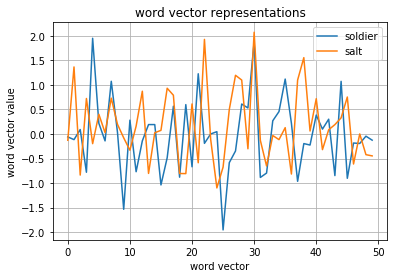

In [44]:
plot_words = ["soldier", "salt"]

for a in plot_words:
    plt.plot(glove_vects[glove_dict[a]])
    
plt.grid(which="both")
plt.title(f'word vector representations')
plt.legend(plot_words)
plt.xlabel('word vector')
plt.ylabel('word vector value')
plt.show()

In the graph above these two words seem similar, but how similar are they exactly? We can use the similarity function from nlp_utils to get the cosine similarity between two words. We compare some words where we expect them to have a high or low similarity and see if the model agrees with our intuition.

In [45]:
for pair in [('army', 'soldier'), 
             ('army', 'child'), 
             ('fruit', 'banana'), 
             ('fruit', 'rock'), 
             ('man', 'woman'),
             ('bottom','carpet') # two random words
             ]:
    
    print('Similarity between {} and {} is: {}'.
          format(pair[0], pair[1], nlp_utils.similarity(pair[0], pair[1], glove_dict, glove_vects)))

Similarity between army and soldier is: 0.7882723393965785
Similarity between army and child is: 0.3570640638863002
Similarity between fruit and banana is: 0.7181406064676134
Similarity between fruit and rock is: 0.328926165386697
Similarity between man and woman is: 0.8860337718495819
Similarity between bottom and carpet is: 0.32863005608735396


We can also go a step further and find the 5 most similar words from a given word, lets try some. Use the most_similar function. 

In [46]:
for word in ['soldier',
             'king',
             'banana',
             'rock',
             'dragon'
            ]:
    
    print('The words most similar to {} are: {}'.format(word, nlp_utils.most_similar(word, glove_dict, glove_vects, 5)))

The words most similar to soldier are: ['wounded', 'killed', 'soldiers', 'army', 'troops']
The words most similar to king are: ['emperor', 'throne', 'son', 'lord', 'prince']
The words most similar to banana are: ['coconut', 'bananas', 'plumaged', 'corn', 'growers']
The words most similar to rock are: ['band', 'album', 'music', 'songs', 'albums']
The words most similar to dragon are: ['sword', 'gods', 'salticidae', 'lion', 'serpent']


Another interesting emergence from these word embeddings is word analogies, for example a man is to a king what a woman is to a ?. The function takes the vector of a word, like "man", subtracts another vector, like "king", and then adds a third vector, like "queen". Then finds the nearest word to the resulting vector. We can try some word analogy triplets with the analogy function.

In [47]:
triplets = [('king', 'man', 'queen'),
            ('university', 'professor', 'school'),
            ('mother', 'daughter', 'father'),
            ('god', 'church', 'devil'),
           ]

for a, b, c in triplets:
    print('{} is to {} as {} is to {}'.format(a, b, c, nlp_utils.analogy(a, b, c, glove_dict, glove_vects, 5)))

king is to man as queen is to ['woman', 'girl', 'her', 'man', 'she']
university is to professor as school is to ['school', '816-822-8448', 'professor', 'college', 'teacher']
mother is to daughter as father is to ['son', 'daughter', 'father', 'married', 'wife']
god is to church as devil is to ['non-institutionalized', 'church', 'st.', 'cathedral', '732-390-4697']


The analogy task is not performing perfectly, but the results are in the ballpark of what we could expect. Its clear that these word embeddings contain a lot of information, while only having 50 dimensions per word.

## Part 2: data preparation

The texts used by Alexander Huth are short stories, so it only makes sense for us to use other short stories as training data for the LSTM. The texts we will use are from [PROJECT GUTENBERG](https://www.gutenberg.org/), it's a dataset with 1000 short stories. 

The stories will need some processing to remove non-story content and cut up the paragraphs. The function pre_process_stories will do the following things for us:
1. Split the stories by chapter and paragraph.
2. Remove all whitespace, \n newlines and non-word content.
3. Split each paragraph into a list of words, and remove all paragraphs that are too short. 

Note: The dataset will become very big when you use many stories, so see how many your machine can handle. 10 stories should be enough to get reasonable results. 

In [48]:
stories_path = "stories.csv"
n_stories = 1

paragraph_size_lim = 20

story_data = nlp_utils.pre_process_stories(stories_path, n_stories, paragraph_size_lim, 'content')

In Alexander Huths second paper, he uses different context lengths to see if different parts of the brain react to which context length. For simplicity we will stick with a single context length of 4. The make_sequences_set function will take the story data and split it up into sequences of seq_len, and the target of the sequence. So if the sequence is Wi, Wi+1, Wi+2, Wi+3, then Wi+4 will be the target word. 

Note: the PAD and max_seq_len are values to pad the context so that the sequential model can take inputs of different context lengths, up to a length of max_seq_len. 

In [49]:
max_seq_len = 20
PAD = 0.0

sequences_2, targets_2 = nlp_utils.make_sequences_set(story_data[0].tolist(), 
                                                          2, glove_vects, glove_dict, max_seq_len, PAD)

Amount of sequences:  4031


## Part 3: training the LSTM

Now that we have prepared the sequences and the targets, we can start building and training an LSTM model! The input of the model will be the word embeddings of a single sequence, the target output will be the index of the target word. 

The model will have the following layers:
1. A masking layer to mask the unused positions in the full sequence length that we established earlier.
2. The first lstm layer, with an input shape of maximum sequence length * the word embedding size.
3. The second lstm layer.
4. The third lstm layer. 
5. A dense layer that with one output node for each unique word in the text, using a sigmoid activation.  

Now that we have a usable dataset made up of a sequence and then a target word, we can start setting up the LSTM model with Keras. We will give each layer the same size as the word embeddings, which is 50. Each model will have 3 LSTM layers, one dense layer with a sigmoid activation, and one softmax layer.  

In [50]:
lstm_layer_size = 50
model_2 = Sequential()
model_2.add(Masking(mask_value=PAD, input_shape=(max_seq_len, 50)))
model_2.add(LSTM(lstm_layer_size, dropout=0.2, input_shape=(max_seq_len, 50), recurrent_dropout=0.2, return_sequences=True, name='lstm1'))
model_2.add(LSTM(lstm_layer_size, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, name='lstm2'))
model_2.add(LSTM(lstm_layer_size, name='lstm3'))
model_2.add(Dense(targets_2.shape[1], activation='linear'))
model_2.compile(loss='cosine_similarity', optimizer='adam', metrics=['cosine_similarity'])   

Now that our model has been compiled, we can start fitting the sequences to the target. This will can take a VERY long time, depending on your machine, the amount of stories you have selected, and the amount of epochs. 

In [51]:
n_epochs = 50
model_2_history = model_2.fit(sequences_2, 
                            targets_2, 
                            epochs=n_epochs, batch_size=sequences_2.shape[0], verbose=1, validation_split=0.01)

Train on 3990 samples, validate on 41 samples
Epoch 1/50
3990/3990 [==============================] - 9s 2ms/step - loss: -0.0137 - cosine_similarity: 0.0137 - val_loss: -0.1609 - val_cosine_similarity: 0.1609
Epoch 2/50
3990/3990 [==============================] - 4s 993us/step - loss: -0.1673 - cosine_similarity: 0.1673 - val_loss: -0.2966 - val_cosine_similarity: 0.2966
Epoch 3/50
3990/3990 [==============================] - 4s 965us/step - loss: -0.2899 - cosine_similarity: 0.2899 - val_loss: -0.3909 - val_cosine_similarity: 0.3909
Epoch 4/50
3990/3990 [==============================] - 2s 582us/step - loss: -0.3797 - cosine_similarity: 0.3797 - val_loss: -0.4561 - val_cosine_similarity: 0.4561
Epoch 5/50
3990/3990 [==============================] - 2s 516us/step - loss: -0.4437 - cosine_similarity: 0.4437 - val_loss: -0.5016 - val_cosine_similarity: 0.5016
Epoch 6/50
3990/3990 [==============================] - 2s 512us/step - loss: -0.4854 - cosine_similarity: 0.4854 - val_loss: 

Epoch 50/50
3990/3990 [==============================] - 2s 616us/step - loss: -0.6896 - cosine_similarity: 0.6896 - val_loss: -0.7119 - val_cosine_similarity: 0.7119


Once the model is done training, we can inspect the performance over each epoch. We want to reach a point where the validation loss starts increasing or stays the same. If we go further we will begin to overfit, and we want to avoid that. When we tested it this was around 50 epochs, so for simplicity we will use this many epochs. 

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


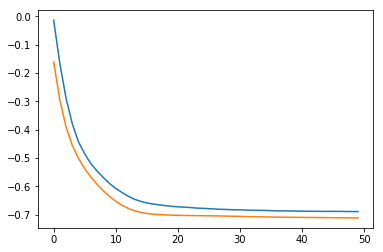

In [52]:
acc = model_2_history.history['loss']
val_acc = model_2_history.history['val_loss']
plt.plot(acc)
plt.plot(val_acc)

Now that we have a trained model, we need a function that can extract the output of the 3rd lstm layer.  

In [53]:
get_output_2 = K.function([model_2.layers[0].input],
                                  [model_2.layers[3].output])

Now we have a function where we can input a sequence and get its representation from the LSTM layer.

In A. Huths paper different representation lengths are used so we will train 2 more models, one with context length 4, and one with context length 6. The code below will do what we did above for context length 2, but now for context length 4 and 6.

In [54]:
get_output_4 = nlp_utils.build_context_rep_function(story_data[0].tolist(), 4, glove_vects, glove_dict)
get_output_6 = nlp_utils.build_context_rep_function(story_data[0].tolist(), 6, glove_vects, glove_dict)

Amount of sequences:  3849
Train on 3810 samples, validate on 39 samples
Epoch 1/50
3810/3810 [==============================] - 5s 1ms/step - loss: 0.0307 - cosine_similarity: -0.0307 - val_loss: -0.1405 - val_cosine_similarity: 0.1405
Epoch 2/50
3810/3810 [==============================] - 2s 629us/step - loss: -0.1077 - cosine_similarity: 0.1077 - val_loss: -0.2694 - val_cosine_similarity: 0.2694
Epoch 3/50
3810/3810 [==============================] - 2s 519us/step - loss: -0.2209 - cosine_similarity: 0.2209 - val_loss: -0.3580 - val_cosine_similarity: 0.3580
Epoch 4/50
3810/3810 [==============================] - 2s 466us/step - loss: -0.3079 - cosine_similarity: 0.3079 - val_loss: -0.4208 - val_cosine_similarity: 0.4208
Epoch 5/50
3810/3810 [==============================] - 2s 468us/step - loss: -0.3745 - cosine_similarity: 0.3745 - val_loss: -0.4681 - val_cosine_similarity: 0.4681
Epoch 6/50
3810/3810 [==============================] - 2s 480us/step - loss: -0.4243 - cosine_simi

Epoch 50/50
3810/3810 [==============================] - 2s 455us/step - loss: -0.6896 - cosine_similarity: 0.6896 - val_loss: -0.7092 - val_cosine_similarity: 0.7092
Amount of sequences:  3667
Train on 3630 samples, validate on 37 samples
Epoch 1/50
3630/3630 [==============================] - 6s 2ms/step - loss: -0.0347 - cosine_similarity: 0.0347 - val_loss: -0.1781 - val_cosine_similarity: 0.1781
Epoch 2/50
3630/3630 [==============================] - 2s 531us/step - loss: -0.1345 - cosine_similarity: 0.1345 - val_loss: -0.3216 - val_cosine_similarity: 0.3216
Epoch 3/50
3630/3630 [==============================] - 2s 477us/step - loss: -0.2469 - cosine_similarity: 0.2469 - val_loss: -0.4074 - val_cosine_similarity: 0.4074
Epoch 4/50
3630/3630 [==============================] - 2s 469us/step - loss: -0.3249 - cosine_similarity: 0.3249 - val_loss: -0.4625 - val_cosine_similarity: 0.4625
Epoch 5/50
3630/3630 [==============================] - 2s 470us/step - loss: -0.3835 - cosine_sim

Epoch 49/50
3630/3630 [==============================] - 2s 596us/step - loss: -0.6904 - cosine_similarity: 0.6904 - val_loss: -0.7038 - val_cosine_similarity: 0.7038
Epoch 50/50
3630/3630 [==============================] - 2s 519us/step - loss: -0.6904 - cosine_similarity: 0.6904 - val_loss: -0.7039 - val_cosine_similarity: 0.7039


At last, we have our models. We can now test with a simple example and see how each context differs, based on the context length.

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


Amount of sequences:  5
Amount of sequences:  3
Amount of sequences:  1


DEBUG:matplotlib.axes._base:update_title_pos


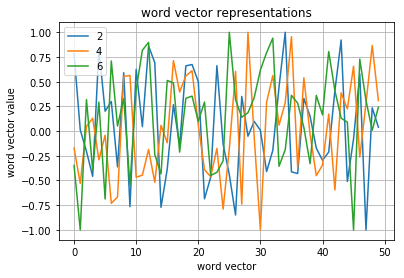

In [64]:
test_sent_1 = [['he', 'and', 'his', 'friends', 'love', 'to', 'drink', ]]

test_2 = nlp_utils.make_sequences_set(test_sent_1, 2, glove_vects, glove_dict, max_seq_len, PAD)
test_4 = nlp_utils.make_sequences_set(test_sent_1, 4, glove_vects, glove_dict, max_seq_len, PAD)
test_6 = nlp_utils.make_sequences_set(test_sent_1, 6, glove_vects, glove_dict, max_seq_len, PAD)

results = [get_output_2(test_2), get_output_4(test_4), get_output_6(test_6)]

for a in results:
    
    plt.plot(np.interp(a[0][-1], (a[0][-1].min(), a[0][-1].max()), (-1, +1)))
    
plt.grid(which="both")
plt.title(f'word vector representations')
plt.xlabel('word vector')
plt.ylabel('word vector value')
plt.legend(['2', '4', '6'])
plt.show()

The representations are for the target word 'drink', with the 2, 4 and 6 previous words used as context in their respective models. Each model creates a completely different representation. The questions we will next attempt to answer is: which is a better representation of brain activity, and is it dependent on brain region?